<a href="https://colab.research.google.com/github/maxifischer/kaggle-circadian-rhythm/blob/master/cell_movement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Questions**
* Do the cells move during the experiment?
* How regular is their signal?
* Is the period 24 hours?
* Do nearby cells oscillate together?
* Do they form chunks or groups, over what range do they work?
* Are there networks formed from time-precedence?





Structure:

methods and technologies used

process of research and analysis (data explorasion, test techniques and so on)

then stick to main method


Problems to mention:
unlabeled data
uneven intensity during the experiment





In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import sqrt 

from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

from scipy.ndimage.filters import uniform_filter, gaussian_filter # to smooth images
from scipy.optimize import minimize # optimization

from sklearn.preprocessing import normalize


In [0]:
import matplotlib as mpl
mpl.rc('image', cmap='gray')

In [0]:
# import seaborn as sns
# sns.set_style('white')

## Data processing


### Reading time series

In [0]:
time_frames = pd.read_csv('data/circadian-rhythm-in-the-brain/data141110.csv')

In [5]:
time_frames.head()

,Image.No.,Frame.No,Time.hrs.
0,40,1,3.750892
1,44,2,3.846050
2,45,3,3.946050
3,46,4,4.046050
4,47,5,4.146050


In [6]:
time_frames.tail()

,Image.No.,Frame.No,Time.hrs.
1680,1730,1681,171.616306
1681,1731,1682,171.716306
1682,1732,1683,171.816306
1683,1733,1684,171.916306
1684,1734,1685,172.016306


In [7]:
time_frames.shape

(1685, 3)

**data141110.csv**  contains image numbers, its frame number and time  
about 1685 frames


### Reading image data

In [8]:
with np.load('data/circadian-rhythm-in-the-brain/flo_image_1.npz') as data:
    im_ids1 = data['image_ids']
    im_stack1 = data['image_stack']

im_stack1.shape

(800, 512, 512)

In [9]:
with np.load('data/circadian-rhythm-in-the-brain/flo_image_2.npz') as data:
    im_ids2 = data['image_ids']
    im_stack2 = data['image_stack']
    
im_stack2.shape

(885, 512, 512)

**flo_image_x.npz** contains two numpy arrays: *image_ids* and *image_stack*

image_ids - names of the images in the 'flo_images' folder

image_stack - 2d array that represents image

---

**image_stak** aray

size: 512x512

values: intensity 


### Some preprocessing

####   Combine image array into one




In [0]:
im_ids = np.concatenate((im_ids1, im_ids2))
im_stack = np.concatenate((im_stack1, im_stack2))

In [0]:
del im_stack1
del im_stack2

In [12]:
print(im_ids.shape)
print(im_stack.shape)

(1685,)
(1685, 512, 512)


## Exploratory analysis

In [0]:
summed_image = np.sum(im_stack, axis=0)

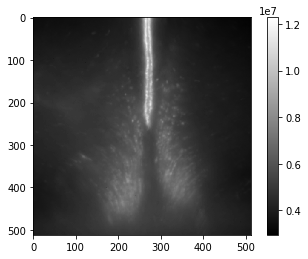

In [14]:
plt.imshow(summed_image)
plt.colorbar()
plt.show()

In [15]:
summed_intensity_images = np.sum(im_stack, axis=(1,2))
summed_intensity_images.shape

(1685,)

In [0]:
timeSeries = time_frames['Time.hrs.']

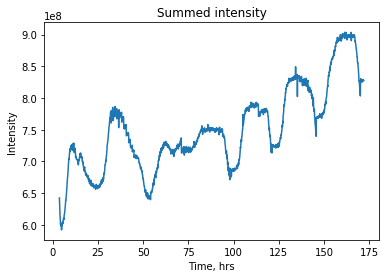

In [17]:
plt.title('Summed intensity')
plt.xlabel('Time, hrs')
plt.ylabel('Intensity')
plt.plot(timeSeries, summed_intensity_images)
plt.show()

In [18]:
timeSeries[0]

3.750891667

In [19]:
duration_in_days = timeSeries.iloc[-1]/24
print('Number of days: %i days, %f minutes'%(int(duration_in_days), (duration_in_days - int(duration_in_days))*60))

day_points = [d*24 for d in range(math.ceil(duration_in_days))]

Number of days: 7 days, 10.040764 minutes


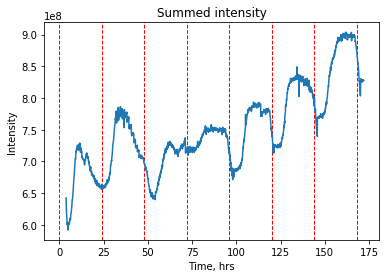

In [20]:
plt.title('Summed intensity')
plt.xlabel('Time, hrs')
plt.ylabel('Intensity')
for dp in day_points:
    plt.axvline(x=dp, linestyle='--', linewidth=1, c='r')
plt.plot(timeSeries, summed_intensity_images)
plt.show()

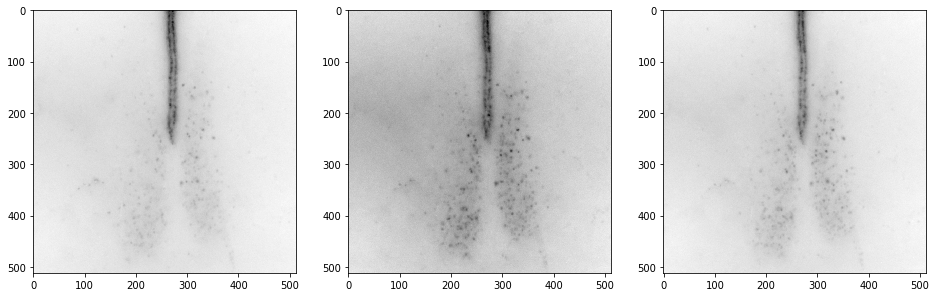

In [21]:
# plt.imshow()

fig, ax = plt.subplots(1,3,figsize=(16,8))
ax[0].imshow( np.invert(im_stack[1200]))
ax[1].imshow( np.invert(im_stack[1600]))
ax[2].imshow( np.invert(im_stack[1350]))
# plt.savefig('bla.png')

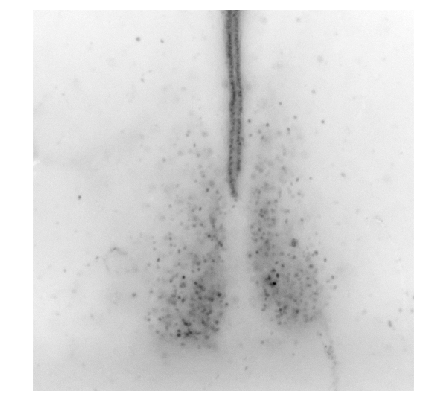

In [22]:
plt.axis('off')
i = 400
fig = plt.gcf()
fig.set_size_inches(7, 7)
plt.imshow(np.invert(im_stack[i]))
fig.savefig("%iinv.png"%(i), bbox_inches='tight')

In [23]:
timeSeries.iloc[1360], timeSeries.iloc[1600]

(139.61630559999998, 163.61630559999998)

In [0]:
current_image_a = im_stack[1600,300:450,150:300]
current_image_b = im_stack[1601,300:450,150:300]
current_image_c = im_stack[1602,300:450,150:300]


In [0]:
def preprocess_im(image, p1=1, p2=99, std1=1.5, std2=3.):
    """
    First normalizes around zero by subtracting a gaussian filter, then clipping the p1,p2 percentiles.
    The result will have float values between 0 and 1.
    """

#     image = (gaussian_filter(image, sigma=std1) - gaussian_filter(image, sigma=std2))

    
    #We run a loop over time - doing clip vectorised crashes the computer for some reason.

    lo = np.percentile(image, p1)
    hi = np.percentile(image, p2)
    return (np.clip(image, lo, hi) - lo) / (hi - lo)
    

In [0]:
def detect_blobs(image, image_to_show, color='white'):
  
#     image = gaussian_filter(image, sigma=0.5)
  
    blobs_log = blob_log(image, threshold=.2, min_sigma=0.6, max_sigma = 10, num_sigma=10, overlap=0.5)
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
    blobs_log1 = blob_log(image, threshold=.15, num_sigma=10, max_sigma = 10, overlap=0.5)
    blobs_log1[:, 2] = blobs_log1[:, 2] * sqrt(2)
    blobs_log2 = blob_log(image,  max_sigma=10, num_sigma=10, threshold=.1, overlap=0.9)
    blobs_log2[:, 2] = blobs_log2[:, 2] * sqrt(2)

    blobs_list = [blobs_log, blobs_log1, blobs_log2]

    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
    ax = axes.ravel()

    for idx, blobs in enumerate(blobs_list):
        ax[idx].imshow(image_to_show)
        for blob in blobs:
            y, x, r = blob
            c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
            ax[idx].add_patch(c)
        ax[idx].set_axis_off()

    plt.tight_layout()
#   plt.show()

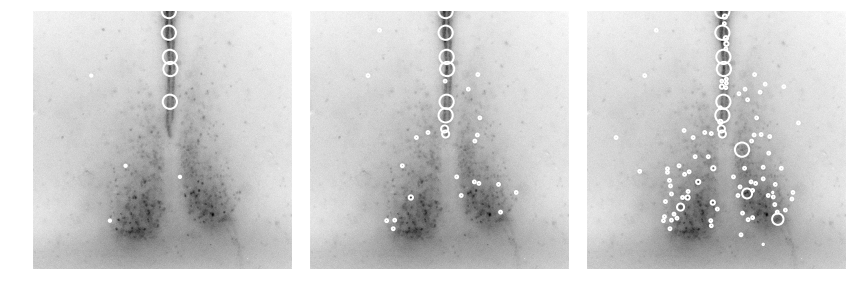

In [27]:
detect_blobs(preprocess_im(im_stack[200]), np.invert(im_stack[200]), color='white')

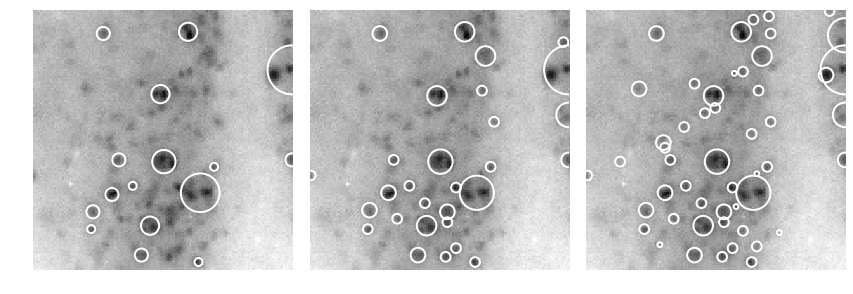

In [28]:
detect_blobs(preprocess_im(current_image_a), np.invert(current_image_a), color='white')
plt.savefig('blobs.png')

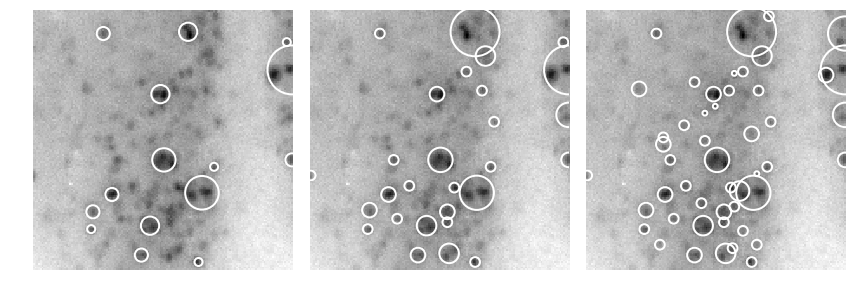

In [29]:
detect_blobs(preprocess_im(current_image_b), np.invert(current_image_b))

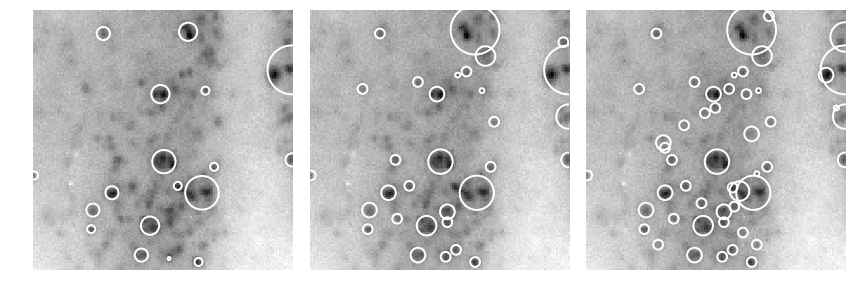

In [30]:
detect_blobs(preprocess_im(current_image_c), np.invert(current_image_c))

In [0]:
def get_blobs(image):
    image = gaussian_filter(image, sigma=0.5)
    blobs_log = blob_log(image, threshold=.15, num_sigma=10, max_sigma = 10, overlap=0.5)
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
    return blobs_log

In [0]:
im_ids = [475, 700, 925, 1150, 1375, 1600]
# im_ids = [400, 640, 880, 1120, 1360, 1600]
# im_ids = [475, 600, 700, 800, 925, 1050, 1150, 1250, 1375, 1500, 1600]
# im_ids = [ 1360, 1600]
ims = [im_stack[idx] for idx in im_ids]

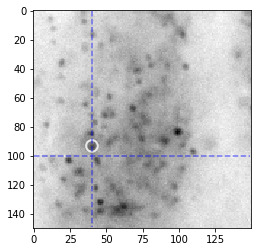

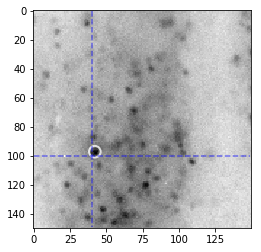

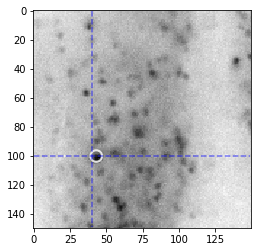

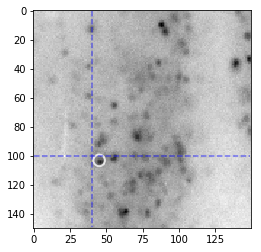

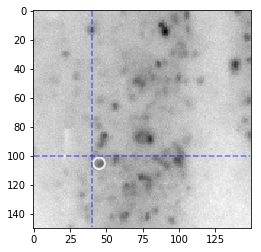

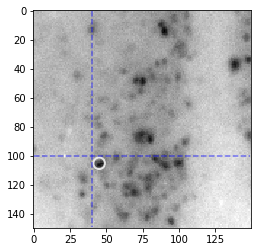

In [33]:
coords = [(40, 93), (42, 97), (43, 100), (45, 103), (45, 105), (45, 105)]
blobs_time_line = []
# for image in im_stack[1000:1020]:
for index, image in enumerate(ims):
  im = image[300:450,150:300]
  fig, ax = plt.subplots(1) 
  ax.imshow(np.invert(im))
  ax.plot([0, 149], [100, 100], 'b--', alpha=0.5)
  ax.plot([40, 40], [0, 149], 'b--', alpha=0.5)
  c = plt.Circle(coords[index], 4, color='white', linewidth=2, fill=False, alpha=0.8)
  ax.add_patch(c)
  plt.savefig('movement_%i'%(index),  bbox_inches='tight')
  plt.show()

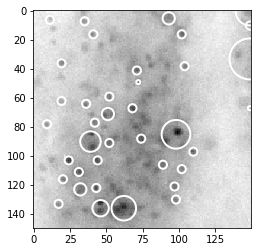

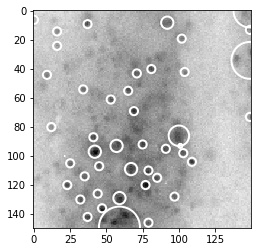

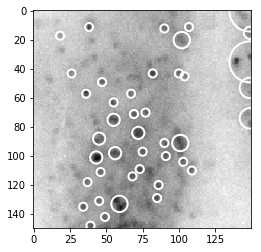

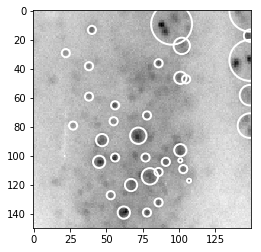

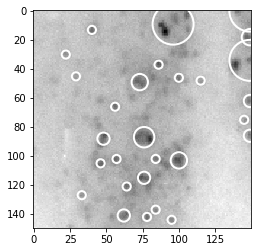

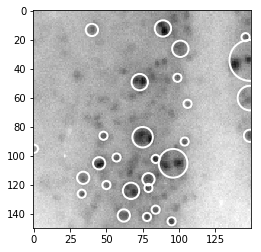

In [34]:
blobs_time_line = []
# for image in im_stack[1000:1020]:
for image in ims:
  im = image[300:450,150:300]
  fig, ax = plt.subplots(1) 
  ax.imshow(np.invert(im))
  blobs_arr = get_blobs(preprocess_im(im))
  blobs_time_line.append(blobs_arr)
  for blob in blobs_arr:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='white', linewidth=2, fill=False)
      ax.add_patch(c)
  plt.show()

In [0]:
def nearest_neighb(current_point, points):
#   print(current_point)
  dists = [(current_point[0]-p[0])**2+(current_point[1]-p[1])**2 for p in points]
  dists = np.array(dists)
  min_id = np.argmin(dists)
  end_point = points[min_id]
  return end_point, min_id, math.sqrt(min(dists)), shift_vector(current_point, end_point)

def shift_vector(start_point, end_point):
  return end_point[0]-start_point[0], end_point[1]-start_point[1]

def to_angle(point, degrees=True):
  if degrees:
    return math.atan2(point[1], point[0])*180/math.pi
  else:
    return math.atan2(point[1], point[0])
  
def to_360(angle):
  if angle < 0:
    return 360 + angle
  else:
    return angle

In [36]:
to_360(-30)

330

In [37]:
sizes = [blobs_arr.shape[0] for blobs_arr in blobs_time_line]
sizes

[38, 44, 42, 35, 28, 28]

In [38]:
blobs_time_line[-2][:6]

array([[144.        ,  95.        ,   2.82842712],
       [142.        ,  78.        ,   2.82842712],
       [141.        ,  62.        ,   4.24264069],
       [137.        ,  84.        ,   2.82842712],
       [127.        ,  33.        ,   2.82842712],
       [121.        ,  64.        ,   2.82842712]])

In [39]:
blobs_time_line[-1][:6]

array([[145.        ,  95.        ,   2.82842712],
       [142.        ,  78.        ,   2.82842712],
       [141.        ,  62.        ,   4.24264069],
       [137.        ,  84.        ,   2.82842712],
       [126.        ,  33.        ,   2.82842712],
       [124.        ,  67.        ,   5.65685425]])

In [0]:
def mean_shift(start, end):
  neighbs = np.array([nearest_neighb(p, end) for p in start])
  dists = np.array(neighbs[:, 2])
  angles = np.array(list(map(to_angle, neighbs[:, 3])))
 
  
  mask = (dists <= 10) & (dists > 0)
  dists = dists[np.where(dists <= 10)]
  angles = angles[mask]
  return dists.mean(), angles

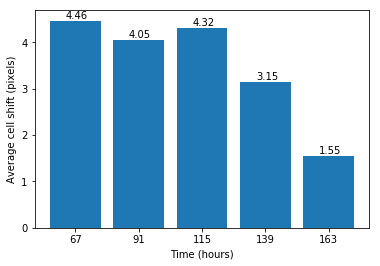

In [41]:

shift = np.zeros(len(blobs_time_line)-1)
angles = []

# print(shift)
for i in range(len(blobs_time_line)-1):
  shift[i], ang = mean_shift(blobs_time_line[i], blobs_time_line[i+1])
  angles.append(ang)

# Plotting  
  
plt.bar(range(len(shift)), shift)

# labels = ['%i'%((day+3)*24+3) for day in range(len(shift))]
labels = [67, 91, 115, 139, 163]

plt.xticks(range(len(shift)), labels)
# Text on the top of each barplot
for i in range(len(shift)):
  plt.text(x = i-0.15 , y = shift[i]+0.05, s = round(shift[i], 2), size = 10)

  
plt.ylabel('Average cell shift (pixels)')
plt.xlabel('Time (hours)')
plt.savefig('average_shift.png')
# plt.show()

[203.19859051364818, 90.0, 206.56505117707798, 0.0, 14.036243467926477, 0.0, 36.86989764584402, 53.13010235415598, 125.53767779197439, 336.0375110254218, 14.036243467926477, 26.56505117707799, 351.86989764584405, 68.19859051364818, 146.30993247402023, 14.036243467926477, 63.43494882292201, 56.309932474020215, 0.0, 26.56505117707799, 26.56505117707799, 189.4623222080256, 0.0, 0.0, 0.0, 0.0, 209.74488129694222, 0.0, 45.0, 32.005383208083494, 341.565051177078]
[18.43494882292201, 201.80140948635182, 21.80140948635181, 0.0, 11.309932474020213, 90.0, 11.309932474020213, 26.56505117707799, 260.5376777919744, 11.309932474020213, 14.036243467926477, 0.0, 0.0, 14.036243467926477, 194.03624346792648, 180.0, 348.69006752597977, 0.0, 75.96375653207353, 11.309932474020213, 0.0, 0.0, 45.0, 45.0, 33.690067525979785, 0.0, 18.43494882292201, 0.0, 164.05460409907712, 0.0, 33.690067525979785, 0.0, 26.56505117707799, 333.434948822922]
[26.56505117707799, 116.56505117707799, 18.43494882292201, 225.0, 350.5

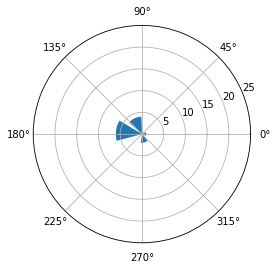

In [42]:
def vizual_polar(angles_to_viz):
  bins_number = 6 # could be 6 8 12
  
  degree_range = 360//bins_number
  bins_value = [i*degree_range for i in range(bins_number)]
  plt.clf()
  width = 2 * np.pi / bins_number
  bins = np.zeros(bins_number)
  for angle in angles_to_viz:
    bins[int(to_360(angle)//degree_range)-1] += 1
  ax = plt.subplot(1, 1, 1, projection='polar')
  ax.set_ylim(0, 25)
#   bars = ax.bar(bins_value, bins)
  bars = ax.bar(range(bins_number), bins)
#   for bar in bars:
#       bar.set_alpha(0.5)
 
#   plt.show()
  
for i in range(len(angles)):
  print([to_360(angl) for angl in angles[i]])
  vizual_polar(angles[i])
  plt.savefig('polar_%i'%(i),  bbox_inches='tight')

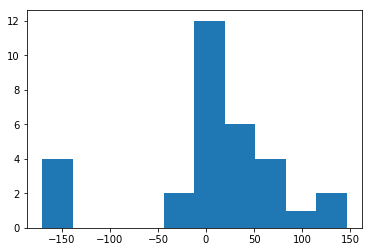

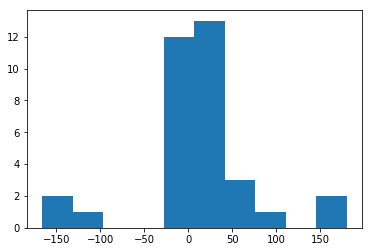

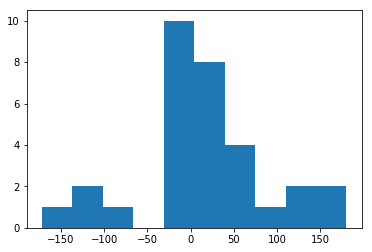

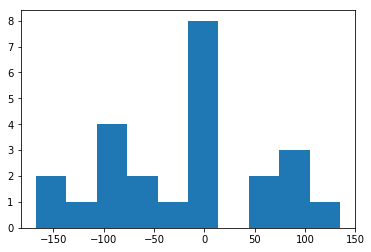

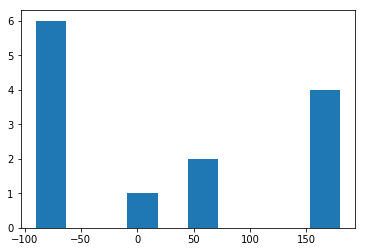

In [43]:
for i in range(len(angles)):
  plt.hist(angles[i])
  plt.show()